# Extract the spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 18th 2017
- update : January 24th 2017


- The goal is to extract the spectrum after the rotation.


-1) First the 1 orders are extracted. One must check the rotation is correct

-2) Check the 2 orders are well aligned along X by looking at the transverse profile : if you see two peaks this means the rotation is bad.

-3) For this the central star light must having been turned off.

In [92]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [93]:
print theNotebook

Extract_Spectrum_HD14943


In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [95]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [96]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [97]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [98]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [99]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [100]:
from IPython.display import Image, display

In [101]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [102]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [103]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [104]:
def subplots_adjust(*args, **kwargs):
    """
    call signature::

      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)

    Tune the subplot layout via the
    :class:`matplotlib.figure.SubplotParams` mechanism.  The parameter
    meanings (and suggested defaults) are::

      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for blank space between subplots
      hspace = 0.2   # the amount of height reserved for white space between subplots

    The actual defaults are controlled by the rc file
    """
    fig = gcf()
    fig.subplots_adjust(*args, **kwargs)
    draw_if_interactive()

### Output directory for images generated in the notebook view (not true fits images)

In [105]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [106]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [107]:
inputdir="./rotated_fitsimages"
object_name='HD14943'

### output fits file

In [108]:
outputdir="./spectrum_fitsspec"

In [109]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [110]:
input_filelist=os.listdir(inputdir) 

In [111]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [112]:
input_filelist[:5]

array(['rotimg_HD14943_20170118_235.fits',
       'rotimg_HD14943_20170118_237.fits',
       'rotimg_HD14943_20170118_239.fits',
       'rotimg_HD14943_20170118_241.fits',
       'rotimg_HD14943_20170118_243.fits'], 
      dtype='|S32')

In [113]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [114]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^rotimg_HD14943_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages
    
    
    

In [115]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [116]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [117]:
print indexes_files

[235 237 239 241 243]


In [118]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [119]:
sorted_numbers=indexes_files[sorted_indexes]

In [120]:
print sorted_indexes

[0 1 2 3 4]


In [121]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [122]:
#sorted_files

## Build full filename
----------------------------

In [123]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [124]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [125]:
print sorted_filenames.shape

(5,)


## Acces to data of  images
----------------------------------

In [126]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [127]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo

In [128]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [129]:
len(all_images)

5

In [130]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    It returns the x0, where the maximum occurs in the image
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=200)
        axarr[iy,ix].set_title(all_titles[index])
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'intput_images.pdf')
    plt.savefig(figfilename)  
    
    return thex0

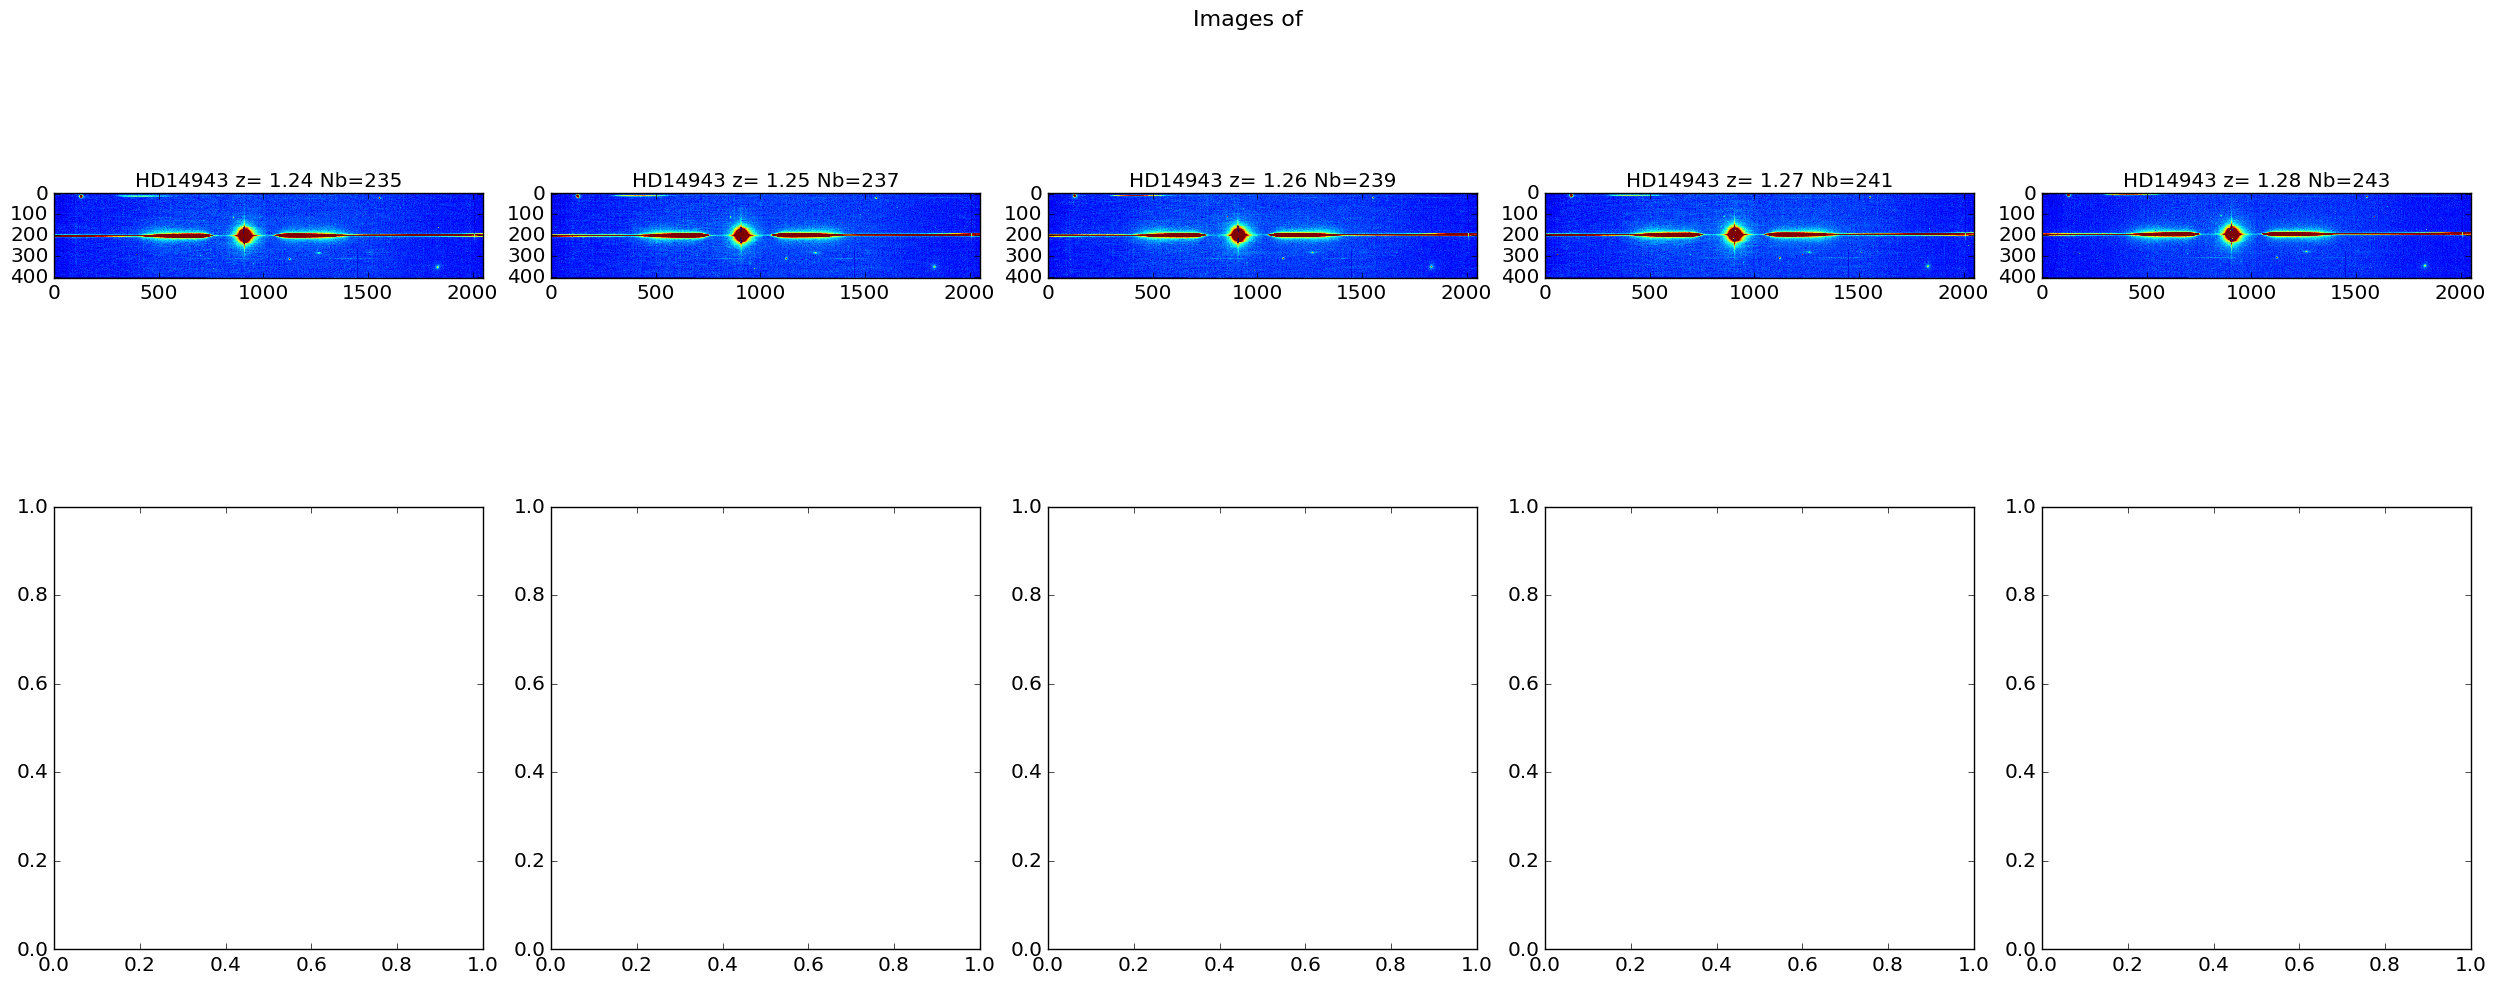

In [131]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

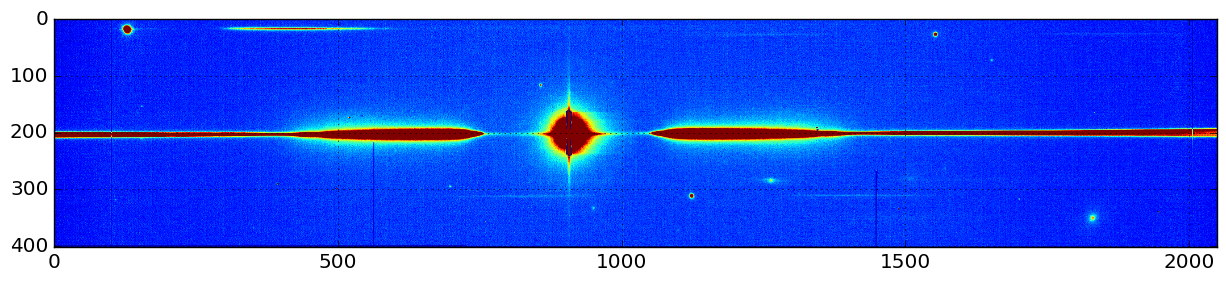

In [132]:
sel=0
plt.figure(figsize=(15,5))
plt.imshow(all_images[sel],vmin=-10,vmax=200)
plt.grid(True)

From the above plot, one sees the star is  850-1000

In [133]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowOneOrder(all_images,all_titles,object_name,all_expo,dir_top_images,figname):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        
        
        ix=index%5
        iy=index/5
        full_image=np.copy(all_images[index])
        
        
        if(all_expo[index]<=0 ): #special case of the first image
            reduc_image=full_image[180:220,1000:2000]  
        else:
            reduc_image=full_image[180:220,1000:2000]/all_expo[index] 
            
            
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=200)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename) 

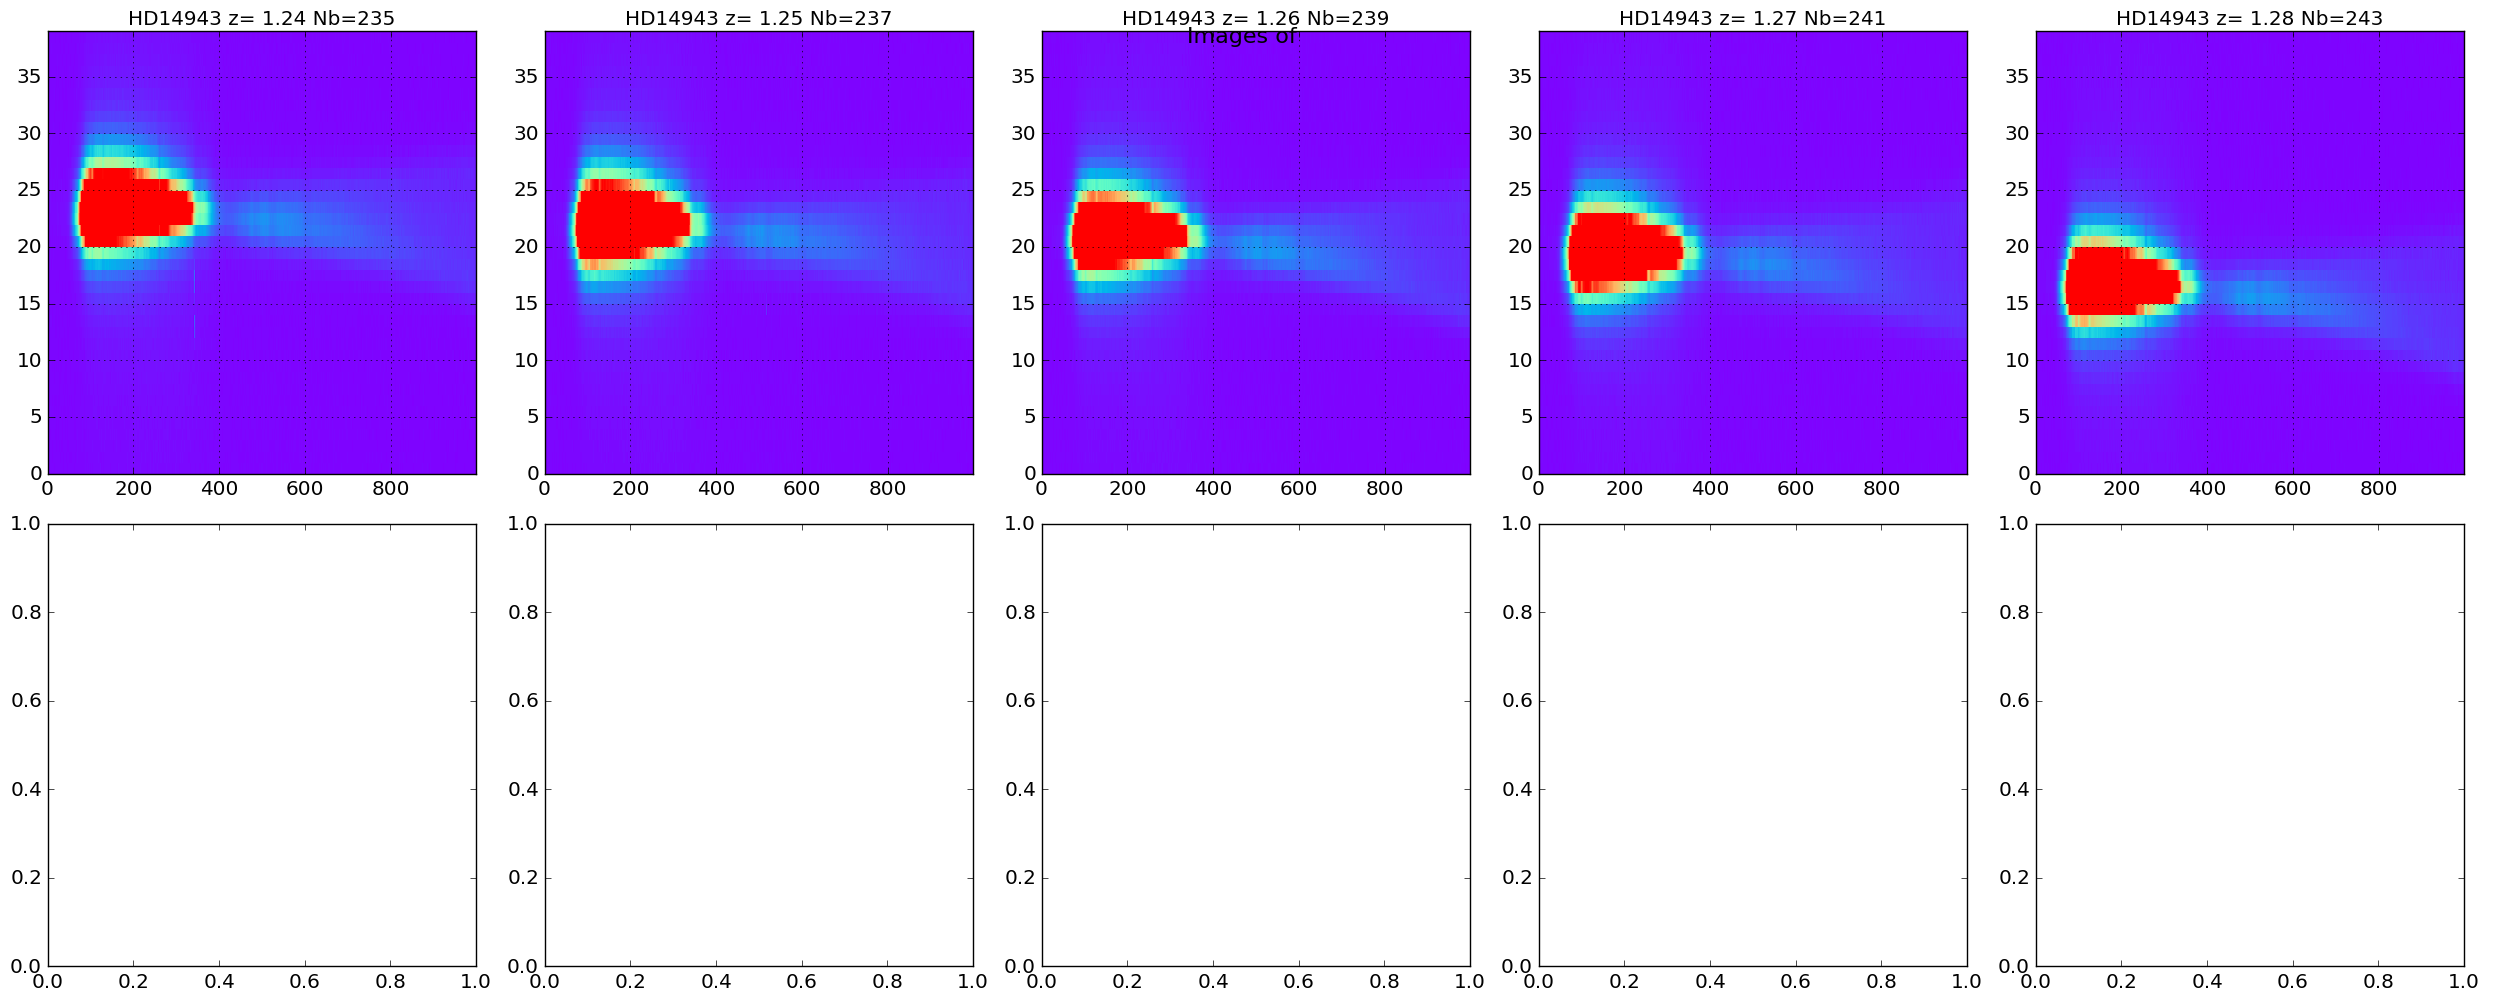

In [134]:
ShowOneOrder(all_images,all_titles,object_name,all_expo,dir_top_images,'firstorderright.pdf')

### Shows the transverse profile

In [135]:
DeltaX=600
w=20
ws=70

In [136]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    The goal is to see in y, where is the spectrum maximum. Returns they0
    
    """

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1

    ### Criteria for spectrum region selection
    DeltaX=600
    w=20
    ws=80
    Dist=4*w
    
    thespectra= []
    thespectraUp=[]
    thespectraDown=[]
    
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        data=np.copy(all_images[index])
        data[:,850:1000]=0 ## TURN OFF CENTRAL STAR
                          ## ------------------------ 
        if(all_expo[index]<=0):            
            yprofile=np.sum(data,axis=1)
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        
        #### Here extract the spectrum around the central star
        #####   Take the sum un bins along y
        
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)

        
        ### Lateral bands to remove sky background
        ### ---------------------------------------
        spectrum2DUp=np.copy(data[y0-w+Dist:y0+w+Dist,:])
        xprofileUp=np.median(spectrum2DUp,axis=0)*2.*float(w)

        spectrum2DDown=np.copy(data[y0-w-Dist:y0+w-Dist,:])
        xprofileDown=np.median(spectrum2DDown,axis=0)*2.*float(w)
        
        
        if(all_expo[index]<=0):
            thespectra.append(xprofile)
            thespectraUp.append(xprofileUp)
            thespectraDown.append(xprofileDown)
        else:
            thespectra.append(xprofile/all_expo[index])
            thespectraUp.append(xprofileUp/all_expo[index]) 
            thespectraDown.append(xprofileDown/all_expo[index]) 

            axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    
    return thespectra,thespectraUp,thespectraDown,they0

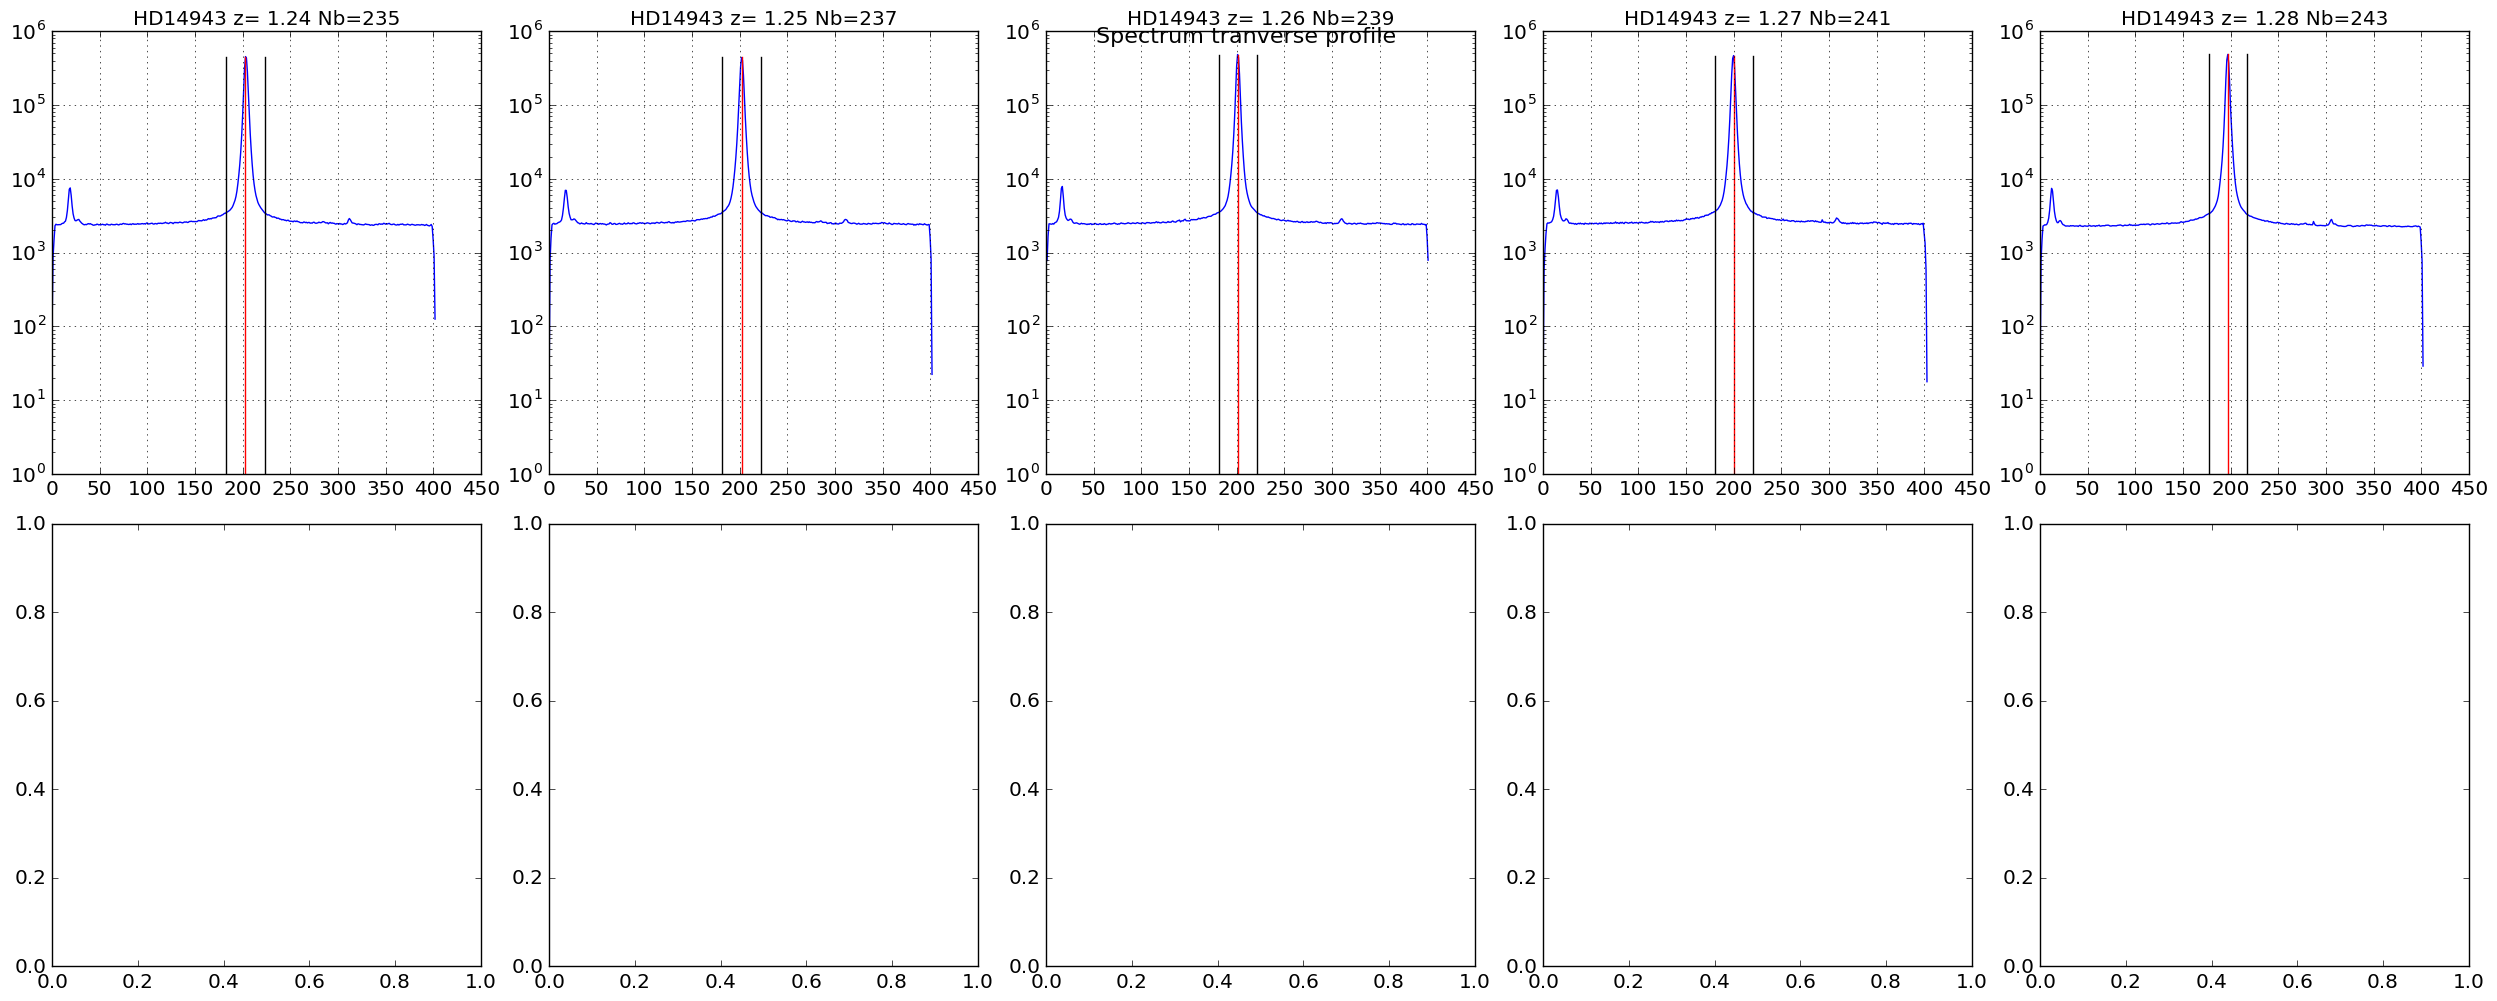

In [137]:
thespectra,thespectraUp,thespectraDown,they0=ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images)

In [138]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        full_image=np.copy(all_images[index])
        x_0=700
        y_0=they0[index]
        if(all_expo[index]<=0):
            reduc_image=full_image[y_0-10:y_0+10,x_0:2000]
        else:
            reduc_image=full_image[y_0-10:y_0+10,x_0:2000]/all_expo[index]
        
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=1100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Right part of spectrum of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'rightorder.pdf')
    
    plt.savefig(figfilename)  

In [139]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        full_image=np.copy(all_images[index])
        x_0=700
        y_0=they0[index]
        if(all_expo[index]<=0):
            reduc_image=full_image[y_0-10:y_0+10,0:x_0]
        else:
            reduc_image=full_image[y_0-10:y_0+10,0:x_0]/all_expo[index]    
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=1100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Left part of spectrum of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'leftorder.pdf')
    plt.savefig(figfilename)  

In [140]:
print len(thex0)

5


In [141]:
#ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

In [142]:
#ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

In [143]:
def CleanBadPixels(spectraUp,spectraDown):
    
    Clean_Up= []
    Clean_Do = []
    Clean_Av = []
    eps=25.   # this is the minumum background Please check
    NBSPEC=len(spectraUp)
    for index in np.arange(0,NBSPEC):
        s_up=spectraUp[index]
        s_do=spectraDown[index]
    
        index_up=np.where(s_up<eps)
        index_do=np.where(s_do<eps)
        
        s_up[index_up]=s_do[index_up]
        s_do[index_do]=s_up[index_do]
        s_av=(s_up+s_do)/2.
        
        Clean_Up.append(s_up)
        Clean_Do.append(s_do)
        Clean_Av.append(s_av)
        
    return Clean_Up, Clean_Do,Clean_Av 

In [144]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

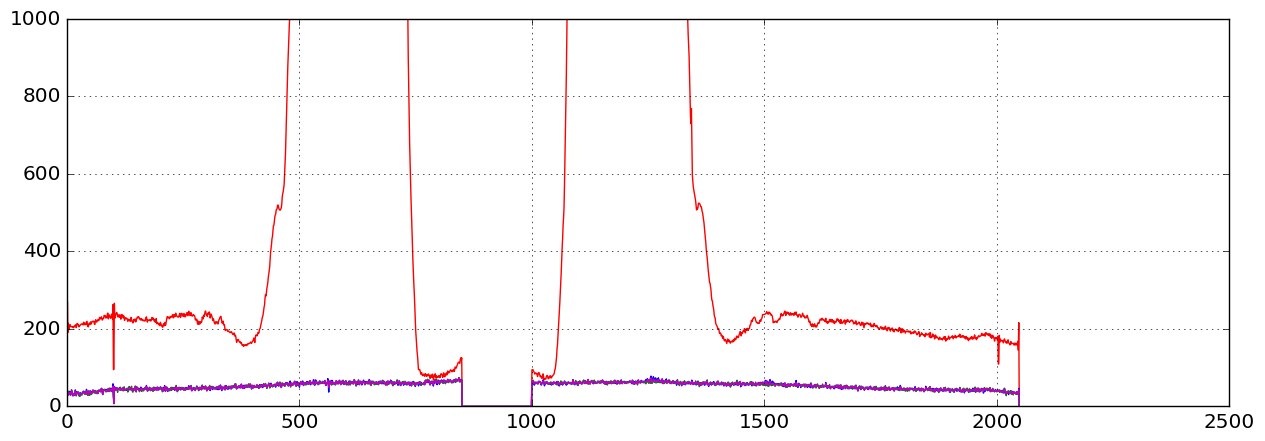

In [179]:
sel=0
plt.figure(figsize=(15,5))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,1000.)
figfilename=os.path.join(dir_top_images,'bckg_sample.pdf')
plt.savefig(figfilename) 

In [177]:
def ShowLongitBackground(spectra,spectraUp,spectraDown,spectraAv,all_titles,object_name,dir_top_images):
    """
    Show the background to be removed to the spectrum
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/5)+1
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,10))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%5
        iy=index/5
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].plot(spectraUp[index],'b-')
        axarr[iy,ix].plot(spectraDown[index],'g-')
        axarr[iy,ix].plot(spectraAv[index],'m-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,500.)
    title='Longitudinal background Up/Down'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
    plt.savefig(figfilename)  
    

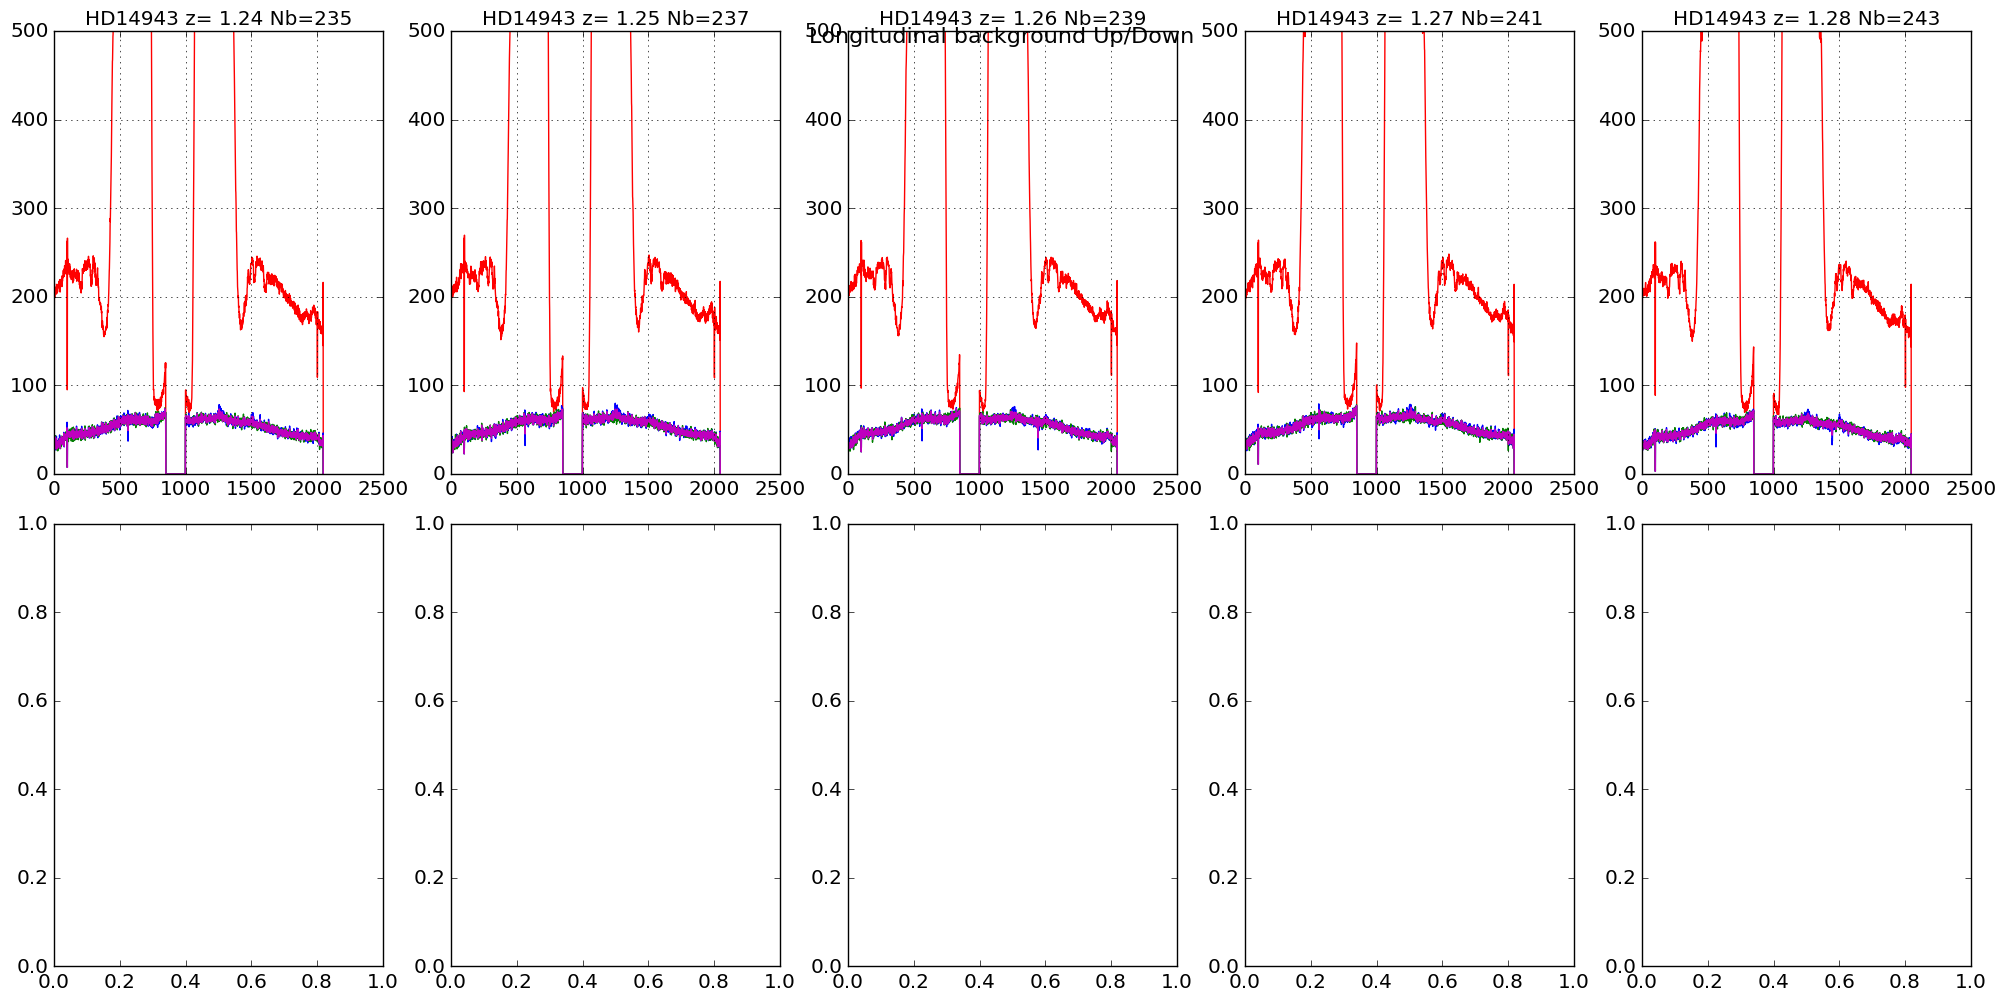

In [178]:
ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,object_name,dir_top_images)

In [148]:
def CorrectSpectrumFromBackground(spectra, background):
    """
    Background Subtraction
    """
    NBSPEC=len(spectra)
        
    corrected_spectra = []
    
    for index in np.arange(0,NBSPEC):
#        if index==0:
#            corrspec=spectra[index]/10.  ##### SPECIAL CASE
#        else:
        corrspec=spectra[index]-background[index]
        corrected_spectra.append(corrspec)
    return corrected_spectra

In [149]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

In [181]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/5)+1
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,10))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%5
        iy=index/5
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,6000.)
    title='Spectrum 1D profile and background Up/Down'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
    plt.savefig(figfilename)  
    

#### Here below, we plot the latera (up and down ) background which has not been subtracted
For me the background remains flat and at zero


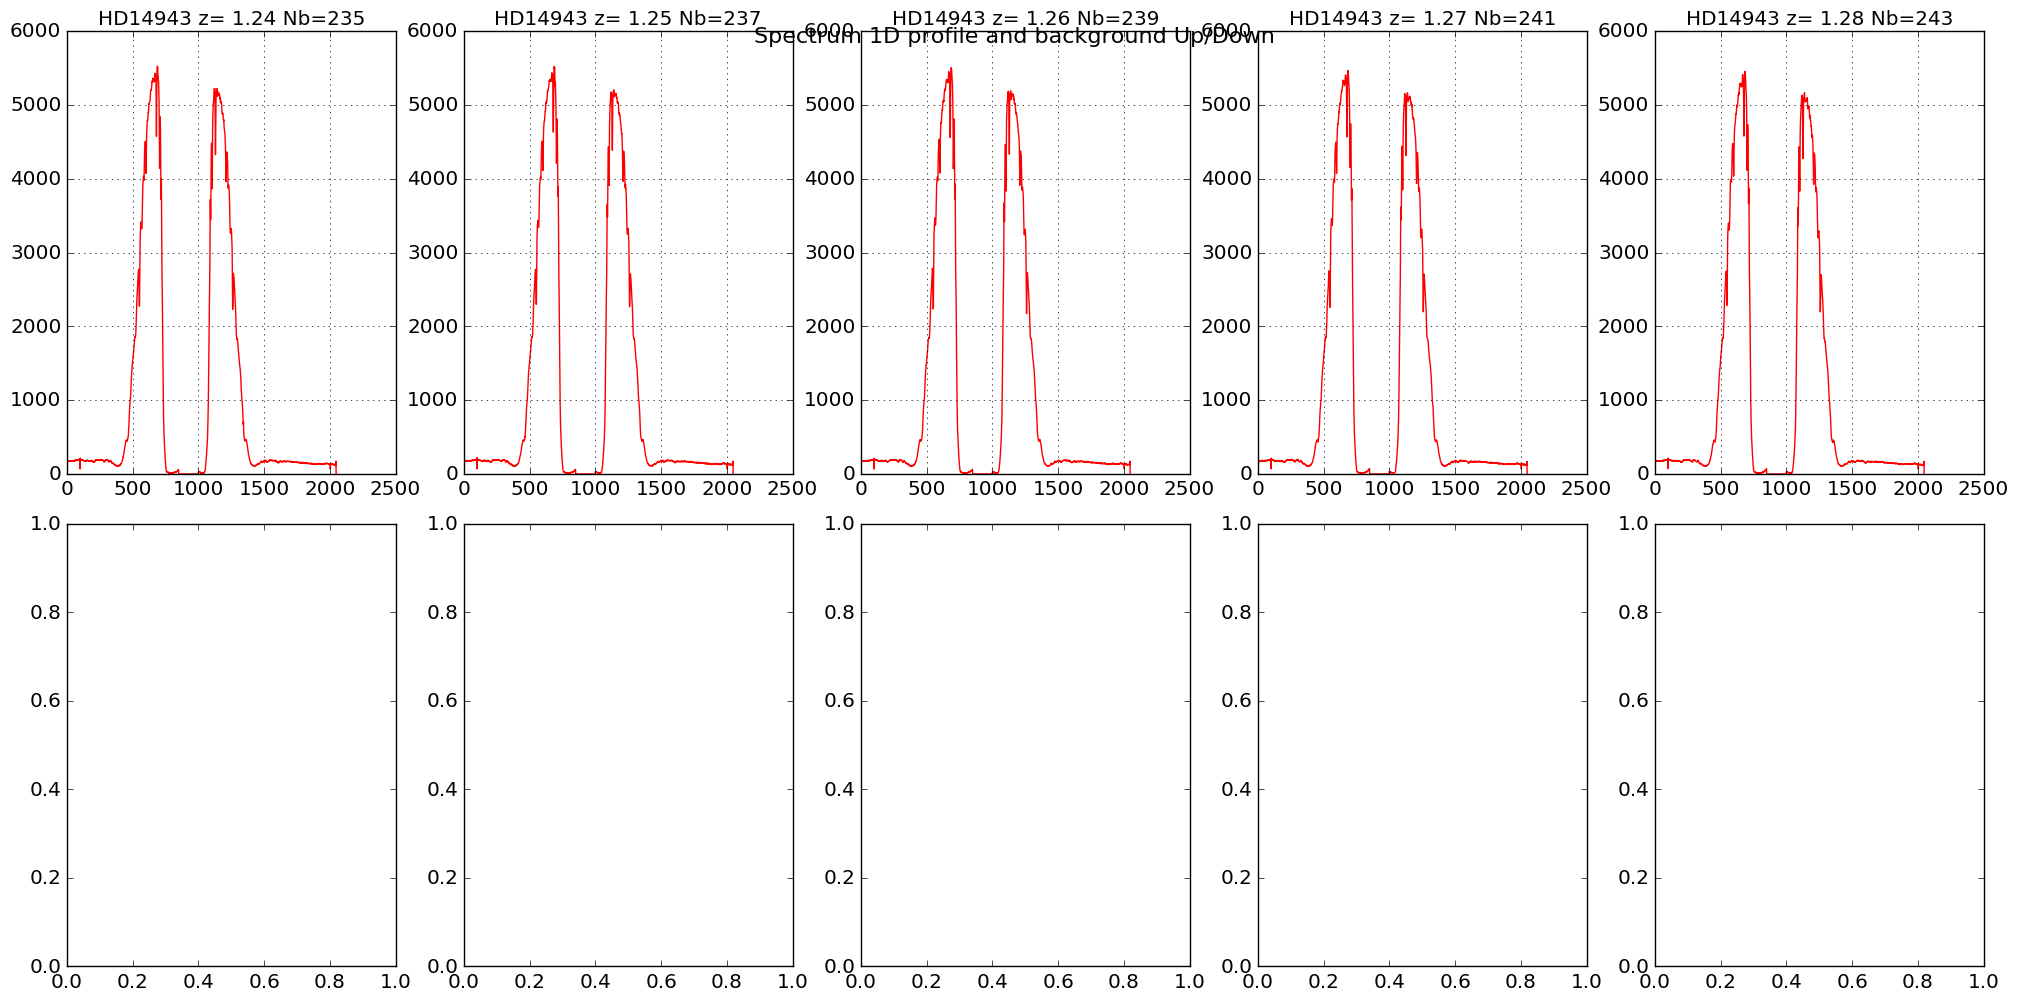

In [182]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,dir_top_images)

## Example of a single spectrum

In [152]:
sel=0
spectrum_sel=thecorrspectra[sel]

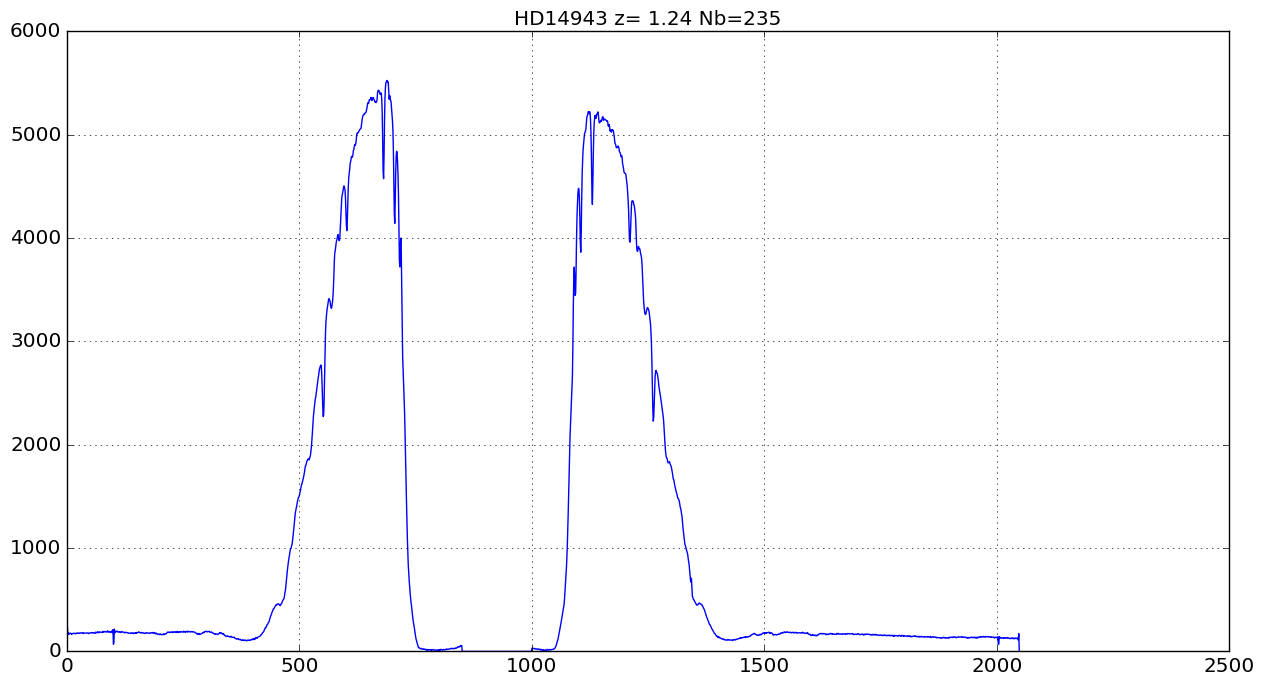

In [183]:
plt.figure(figsize=(15,8))
plt.plot(spectrum_sel)
title=all_titles[sel]
plt.title(title)
plt.grid(True)
#plt.ylim(0,5000.)
figfilename=os.path.join(dir_top_images,'singlespec_sample.pdf')
plt.savefig(figfilename) 

## Cut the spectrum into two left/right part

In [154]:
xmin_center=500
xmax_center=1000
skybg=1

In [155]:
def GetSpectrumBackground(inspectra,start,stop,skybg):
    '''
    Return the background    
    '''
    cropedbg=inspectra[start:stop]
    purebg=cropedbg[np.where(cropedbg!=skybg)]  # remove region of the bing star
    
    return purebg

In [156]:
def SeparateSpectra(inspectra,x0):
    '''
    Cut the two spectra
    '''
    rightspectra=inspectra[x0:]
    revleftspectra=inspectra[:x0]
    leftspectra=   revleftspectra[::-1]
    #rightspectra=rightspectra[np.where(rightspectra>0)]
    #leftspectra=leftspectra[np.where(leftspectra>0)]
    
    return leftspectra,rightspectra

In [157]:
def DiffSpectra(spec1,spec2,bg):
    '''
    Make the difference of the tow spectra 
    
    '''
    N1=spec1.shape[0]
    N2=spec2.shape[0]
    N=np.min([N1,N2])
    spec1_croped=spec1[0:N]
    spec2_croped=spec2[0:N]
    diff_spec=np.average((spec1_croped-spec2_croped)**2)/bg**2
    return diff_spec  

In [158]:
def FindCenter(fullspectrum,xmin,xmax,specbg):
    '''
    '''   
    all_x0=np.arange(xmin,xmax,1)
    NBPOINTS=np.shape(all_x0)
    chi2=np.zeros(NBPOINTS)
    for idx,x0 in np.ndenumerate(all_x0):
        spec1,spec2=SeparateSpectra(fullspectrum,x0)
        chi2[idx]=DiffSpectra(spec1,spec2,specbg)
    return all_x0,chi2

In [159]:
all_candidate_center,all_chi2=FindCenter(spectrum_sel,xmin_center,xmax_center,1)

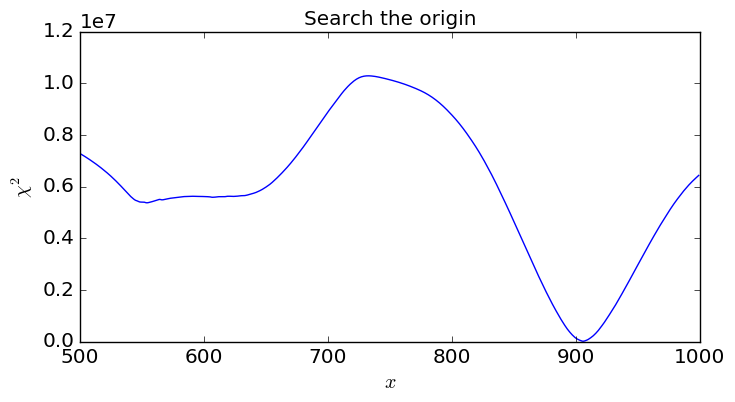

In [160]:
fig = plt.figure(figsize=(8,4))
plt.plot(all_candidate_center,all_chi2)
plt.title('Search the origin')
plt.ylabel('$\chi^2$')
plt.xlabel('$x$')
#plt.ylim(0,200.)

In [161]:
# find where is the minimum of chi2
indexmin=np.where(all_chi2==all_chi2.min())[0]
theorigin=all_candidate_center[indexmin]
print indexmin[0],theorigin[0],all_chi2.min()

406 906 10602.9602286


In [162]:
spec1,spec2=SeparateSpectra(spectrum_sel,theorigin[0])

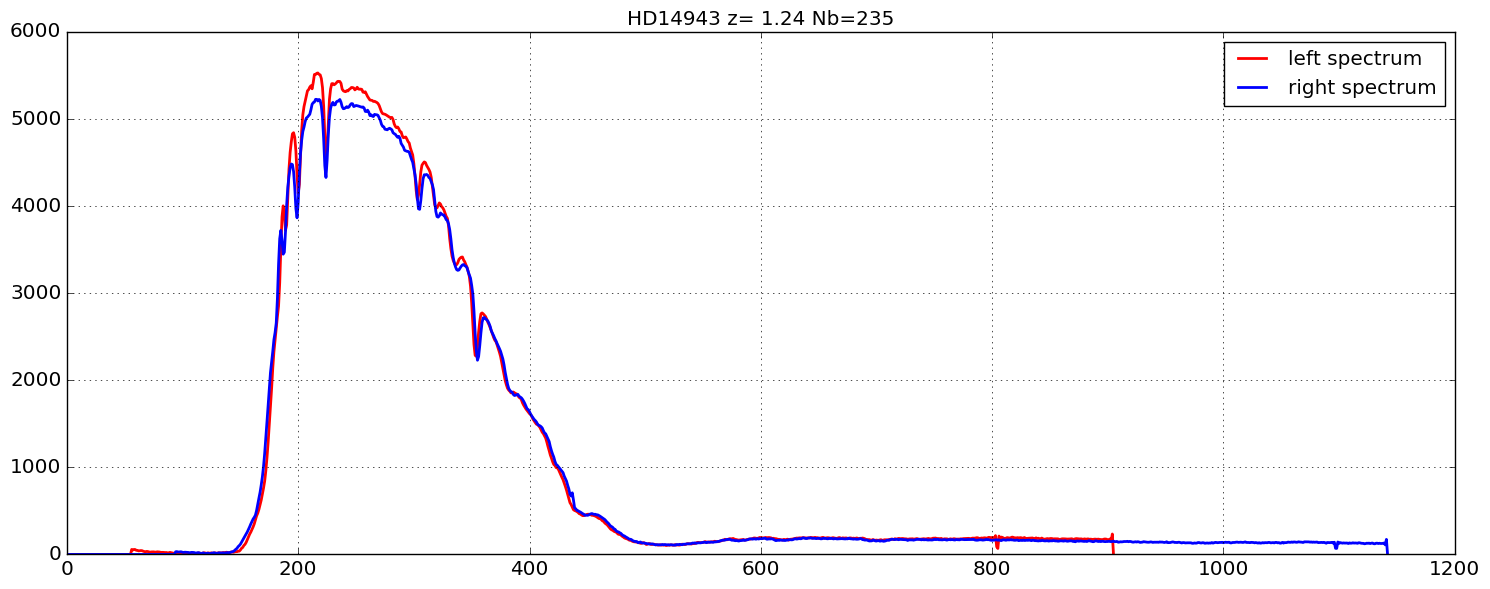

In [163]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(spec1,'r-',lw=2,label='left spectrum')
ax.plot(spec2,'b-',lw=2,label='right spectrum')
plt.title(title)
plt.tight_layout()
plt.grid(True)
plt.legend(loc='best')

## Split Spectrum into two parts
----------------------------------------------

In [164]:
def SplitSpectrumProfile(spectra,all_titles,object_name):
    """
    SplitSpectrumProfile: Split the spectrum in two parts
    =====================
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/5)+1
    
    skybg=1
    spectra_left=[]
    spectra_right=[]
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%5
        iy=index/5

        spectrum_sel=spectra[index]    
        all_candidate_center,all_chi2=FindCenter(spectrum_sel,xmin_center,xmax_center,skybg)
        
        indexmin=np.where(all_chi2==all_chi2.min())[0]
        theorigin=all_candidate_center[indexmin]
        
        #print index, theorigin
        
        spec1,spec2=SeparateSpectra(spectrum_sel,theorigin[0])
        
        spectra_left.append(spec1)
        spectra_right.append(spec2)
        
        axarr[iy,ix].plot(spec1,'r-',lw=1,label='left')
        axarr[iy,ix].plot(spec2,'b-',lw=1,label='right')
        axarr[iy,ix].legend(loc='best')                  
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_ylim(0.,200.)
    
    title='Two 1D Spectra 1D for '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'split_spectra.pdf')
    plt.savefig(figfilename) 
    
    return spectra_left,spectra_right

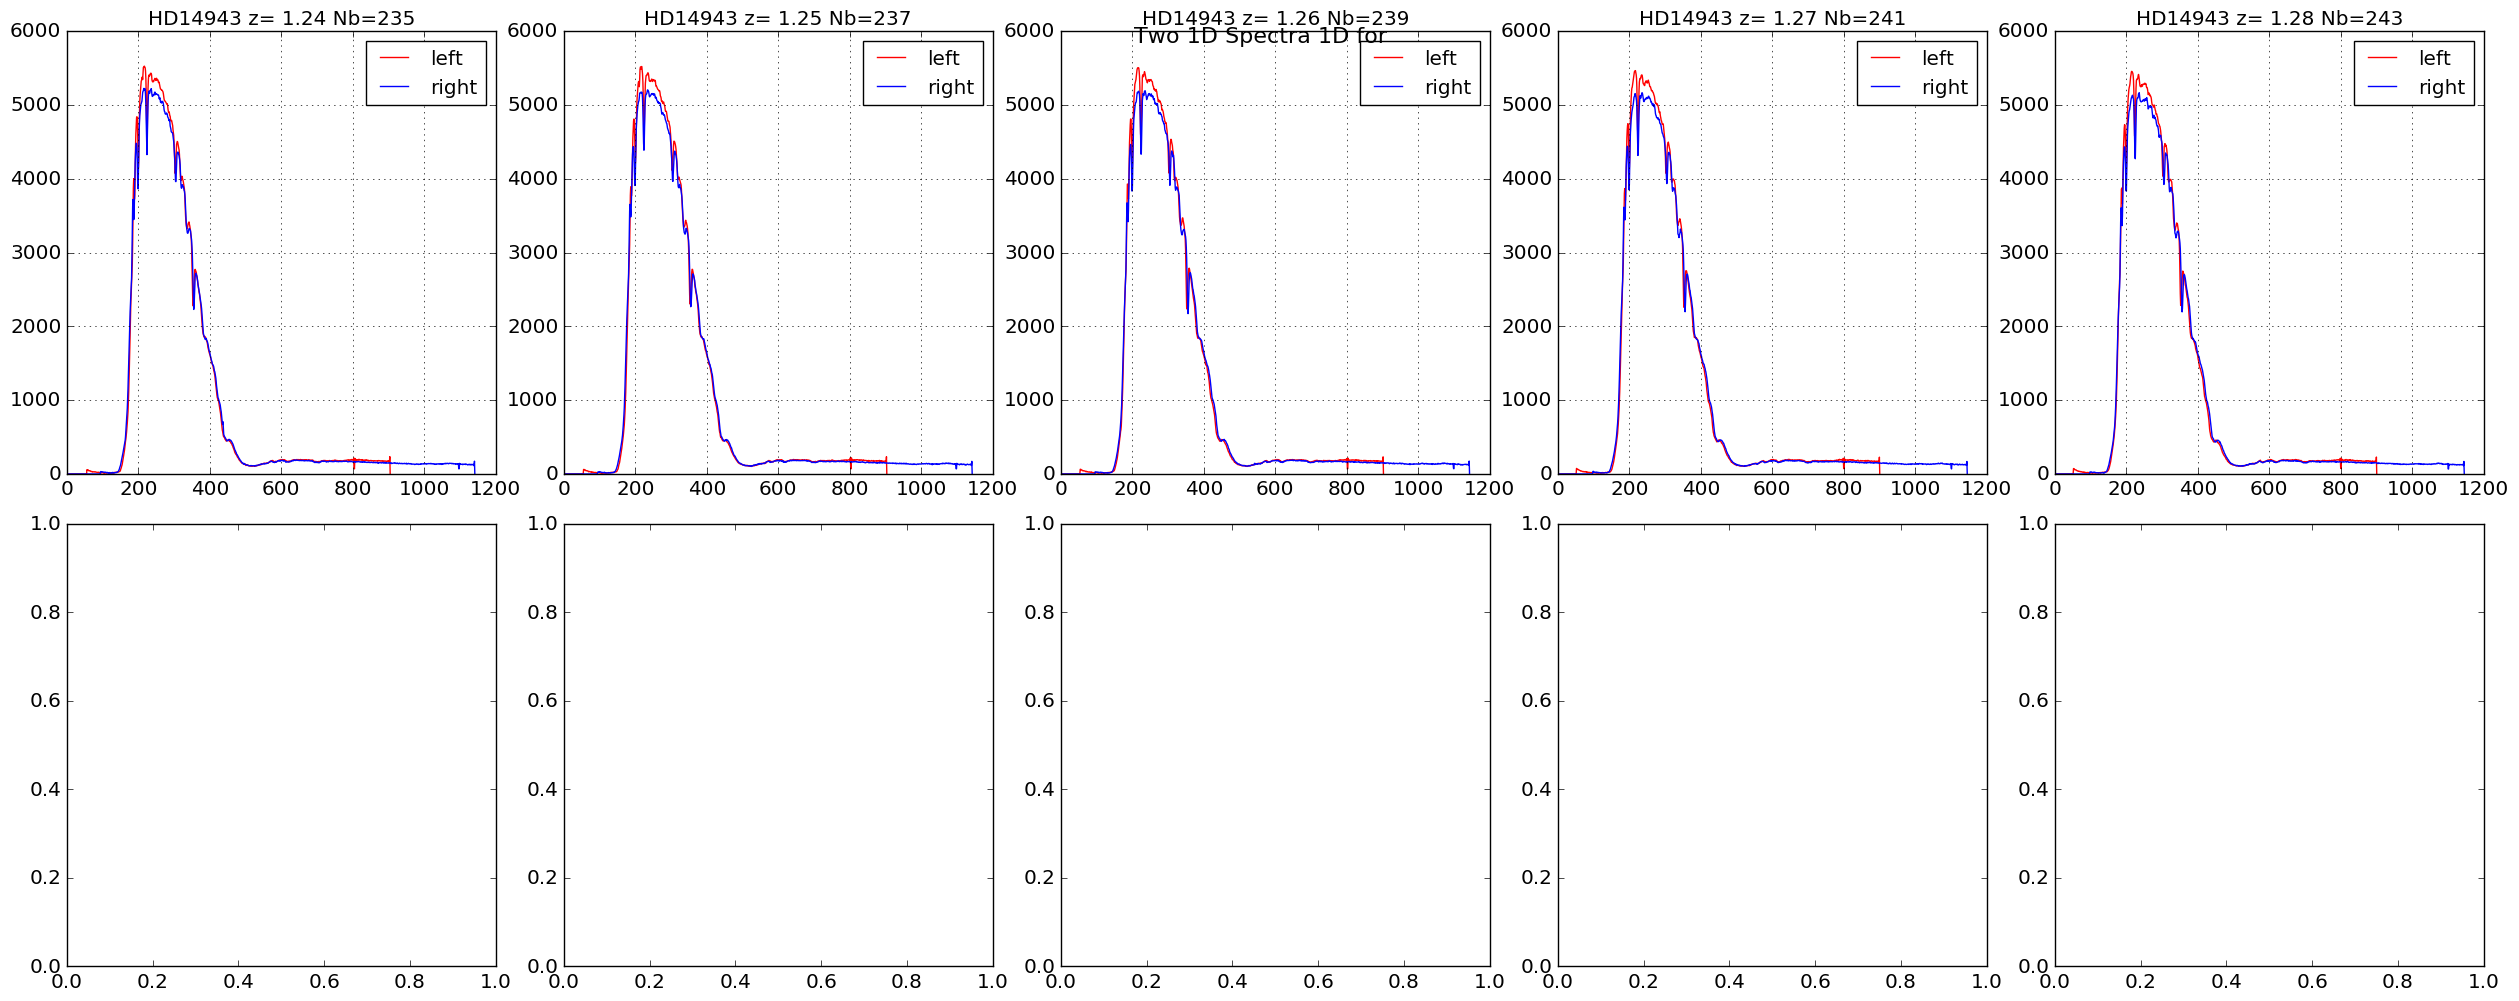

In [165]:
spectra_left,spectra_right=SplitSpectrumProfile(thecorrspectra,all_titles,object_name)

In [166]:
def SupressDeadPixel(spectra,imin,imax,frac,all_titles,object_name):
    """
    SupressDeadPixel:
    =====================
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/5)+1
    
    skybg=1
    spectra_list=[]
   
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%5
        iy=index/5

        spectrum_sel=np.copy(spectra[index])    
        
        for ipix in np.arange(imin,imax):
            thecurrent=spectrum_sel[ipix]
            theprevious=spectrum_sel[ipix-1]
            thenext=spectrum_sel[ipix+1]
            theav=np.mean(np.array([theprevious,thenext]))
            theratio=np.abs(thecurrent-theav)/theav
            if theratio > frac:
                spectrum_sel[ipix]=theav
                
            
        spectra_list.append(spectrum_sel)
        
        axarr[iy,ix].plot(spectrum_sel,'r-',lw=2)
        
        #axarr[iy,ix].legend(loc='best')                  
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    
    title=' Supress dead pixels for '.format(object_name)
    plt.suptitle(title,size=16)
    
    return spectra_list

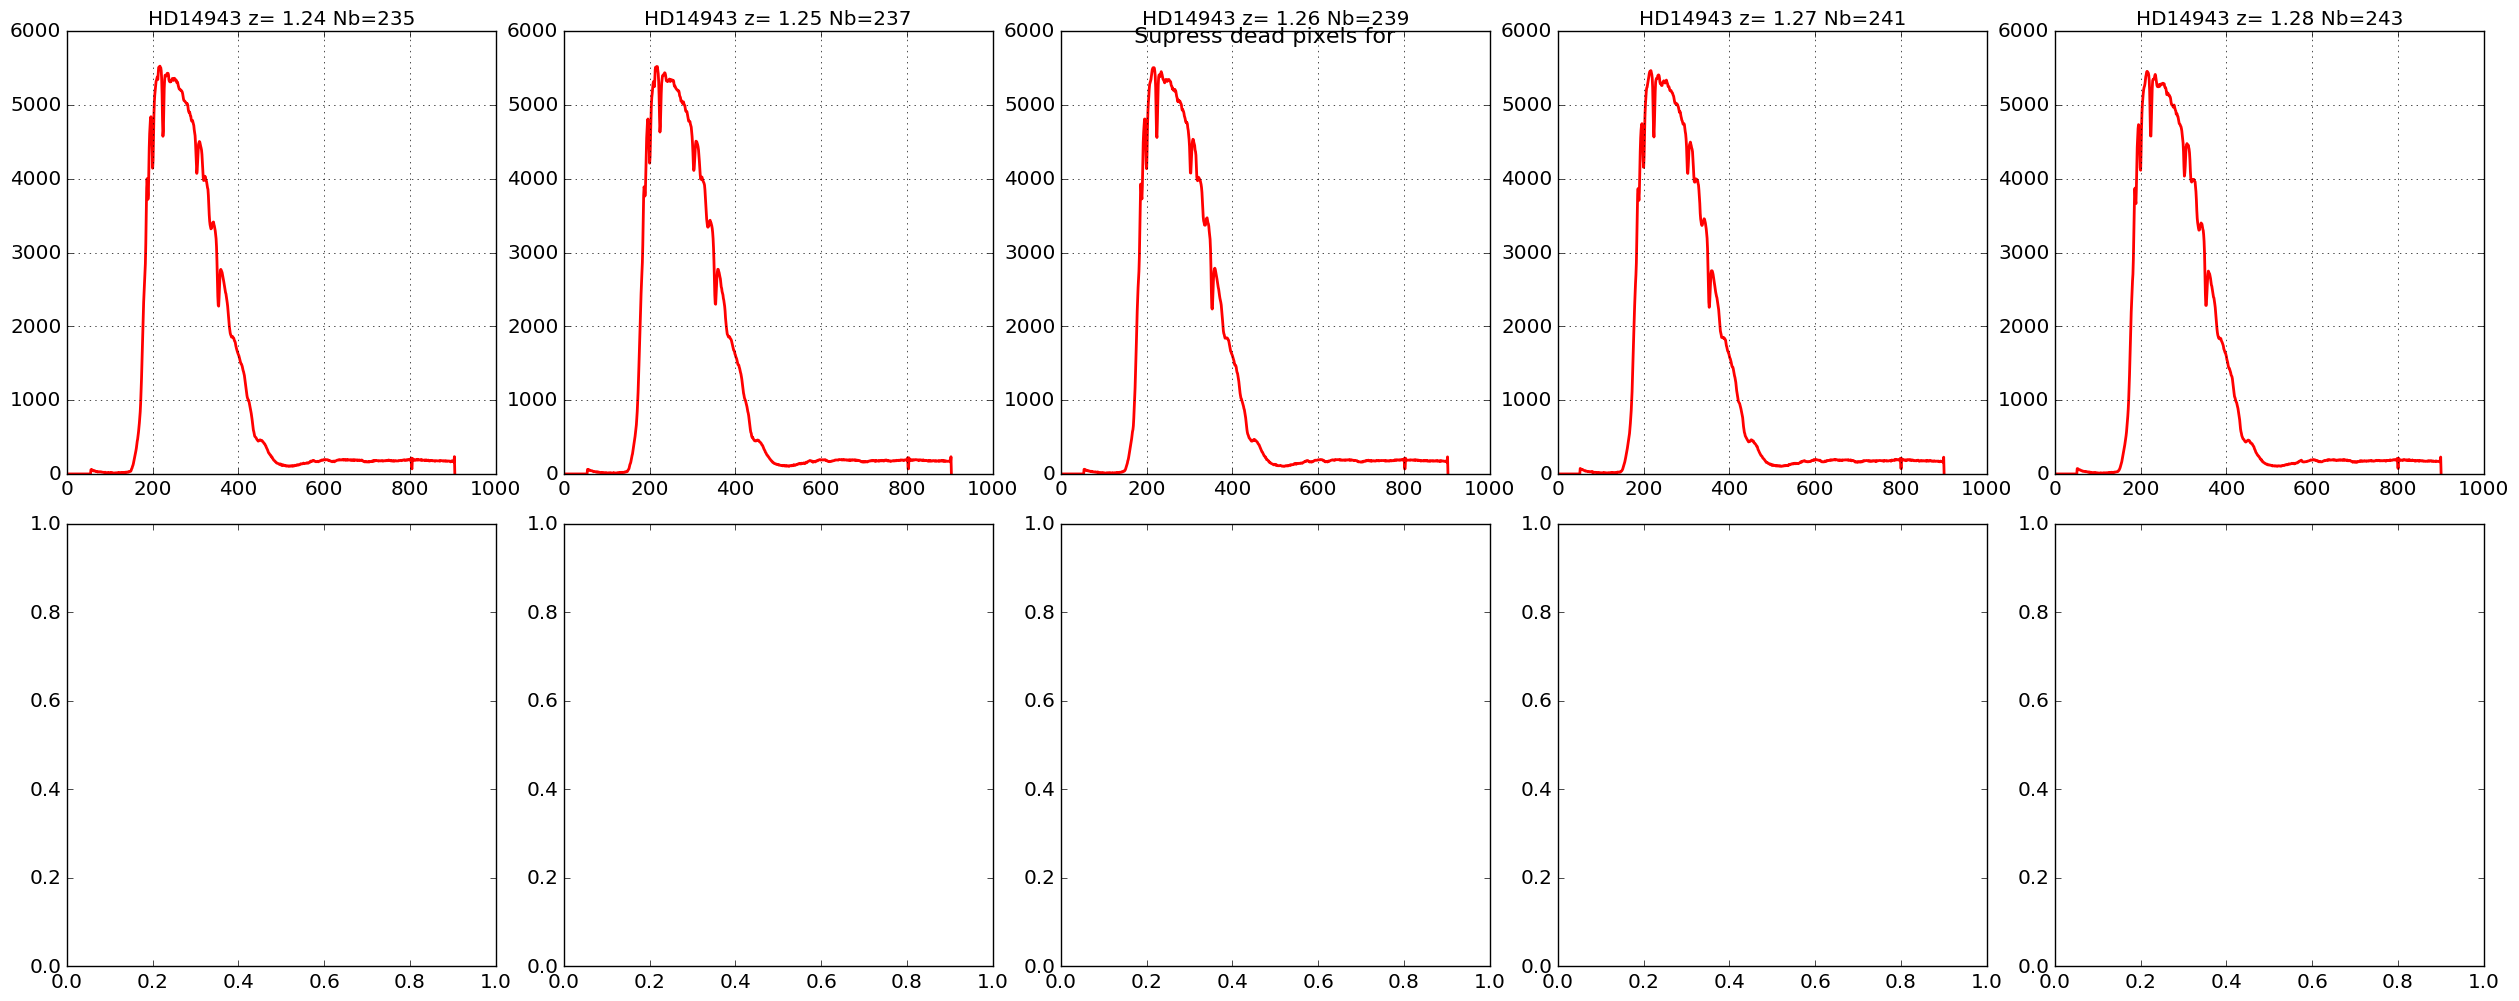

In [167]:
new_left_spectra=SupressDeadPixel(spectra_left,150,500,0.5,all_titles,object_name)

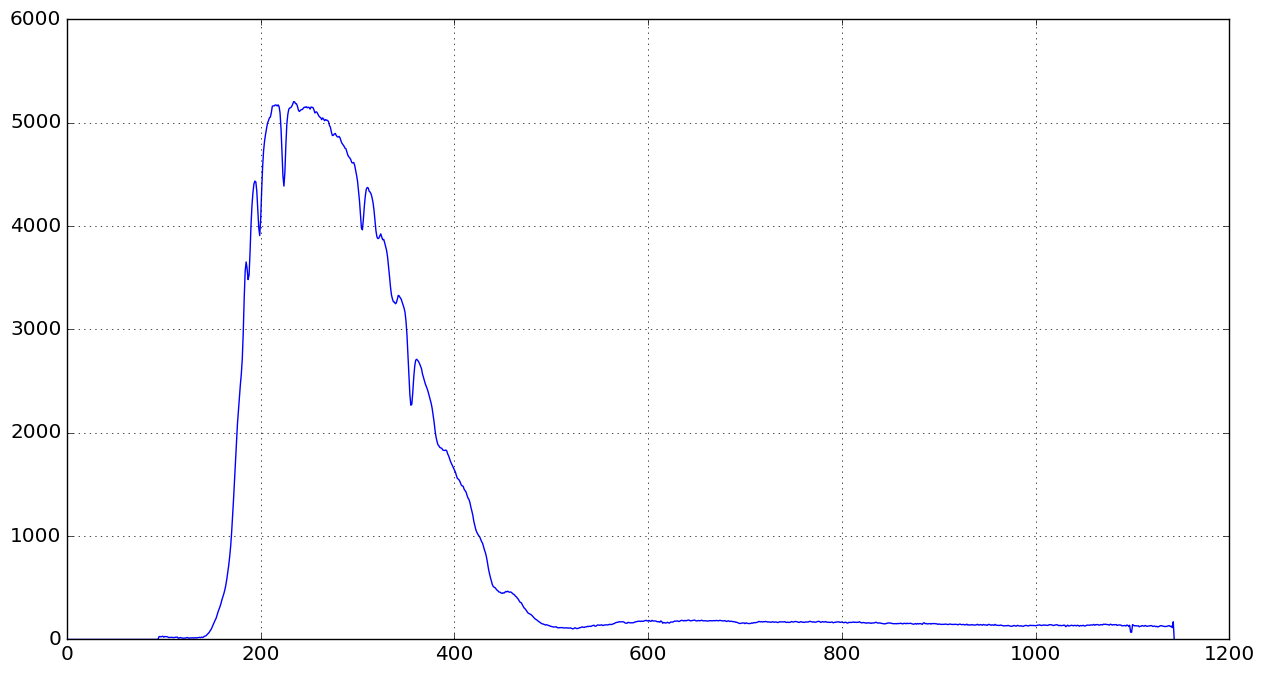

In [168]:
plt.figure(figsize=(15,8))
plt.plot(spectra_right[1])
plt.grid(True)

## Gain Calibration

In [169]:
gains=np.linspace(0.5,1.5,1000)
NBGAINS=gains.shape[0]
chi2New=np.zeros(NBGAINS)

In [170]:
def DiffAmplitudes(sp1,sp2,gain,basebg):
    '''
    get the differences of the spectra for that gain
    '''    
    return DiffSpectra(gain*sp1,sp2,basebg)

In [171]:
thegain=gains[np.where(chi2New==chi2New.min())]
print thegain

[ 0.5         0.501001    0.502002    0.503003    0.504004    0.50500501
  0.50600601  0.50700701  0.50800801  0.50900901  0.51001001  0.51101101
  0.51201201  0.51301301  0.51401401  0.51501502  0.51601602  0.51701702
  0.51801802  0.51901902  0.52002002  0.52102102  0.52202202  0.52302302
  0.52402402  0.52502503  0.52602603  0.52702703  0.52802803  0.52902903
  0.53003003  0.53103103  0.53203203  0.53303303  0.53403403  0.53503504
  0.53603604  0.53703704  0.53803804  0.53903904  0.54004004  0.54104104
  0.54204204  0.54304304  0.54404404  0.54504505  0.54604605  0.54704705
  0.54804805  0.54904905  0.55005005  0.55105105  0.55205205  0.55305305
  0.55405405  0.55505506  0.55605606  0.55705706  0.55805806  0.55905906
  0.56006006  0.56106106  0.56206206  0.56306306  0.56406406  0.56506507
  0.56606607  0.56706707  0.56806807  0.56906907  0.57007007  0.57107107
  0.57207207  0.57307307  0.57407407  0.57507508  0.57607608  0.57707708
  0.57807808  0.57907908  0.58008008  0.58108108  0

### prepare outputfilename

In [172]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [173]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_HD14943_20170118_235.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_20170118_237.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_20170118_239.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_20170118_241.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_20170118_243.fits']

### Save outputfilename

In [174]:
#for idx,file in np.ndenumerate(newfullfilenames):
#    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=spectra_right[idx[0]])
#    thdulist = fits.HDUList(prihdu)
#    thdulist.writeto(file,clobber=True)

In [175]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='RawLeftSpec',format='E',array=spectra_left[idx[0]])
    col2=fits.Column(name='RawRightSpec',format='E',array=spectra_right[idx[0]])
    cols=fits.ColDefs([col1,col2])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)